In [1]:
import ipdb
import torch
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
import scipy as sp
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import math
from torch import nn

In [3]:
G = nx.Graph(name='G')

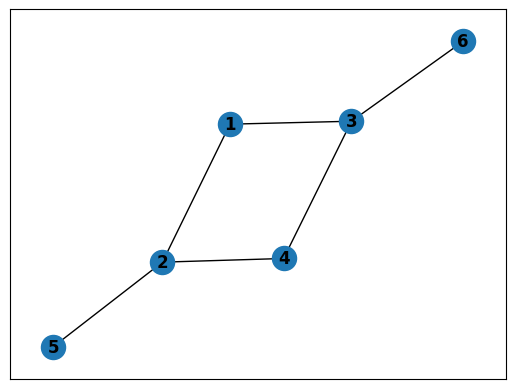

In [4]:
for i in range(1,7):
    G.add_node(i, name=i)
edges = [(1,2), (1,3), (2,4), (2,5), (3,4), (3,6) ]
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=True, font_weight='bold')
plt.show()

In [5]:
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

/tmp/ipykernel_48894/1151363033.py:1: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  A = np.array(nx.attr_matrix(G, node_attr='name')[0])
/tmp/ipykernel_48894/1151363033.py:2: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  X = np.array(nx.attr_matrix(G, node_attr='name')[1])


In [6]:
AX = np.dot(A,X)

In [7]:
G_self_loops = G.copy()

self_loops = []
for i in range(1, 1+ G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

In [8]:
print('Edges of G with self-loops:\n', G_self_loops.edges)

Edges of G with self-loops:
 [(1, 2), (1, 3), (1, 1), (2, 4), (2, 5), (2, 2), (3, 4), (3, 6), (3, 3), (4, 4), (5, 5), (6, 6)]


In [9]:
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])

/tmp/ipykernel_48894/2223732105.py:1: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])


In [10]:
A_hatX = np.dot(A_hat, X)
print('A_hatX:\n', A_hatX)

A_hatX:
 [[ 6.]
 [12.]
 [14.]
 [ 9.]
 [ 7.]
 [ 9.]]


In [11]:
edge_List = G_self_loops.edges() 
Deg_Mat = [[i, 0] for i in G_self_loops.nodes()]

for element in edge_List:
  if element[0] != element[1]:
    Deg_Mat[element[0] - 1][1] += 1
    Deg_Mat[element[1] - 1][1] += 1
  else :
    Deg_Mat[element[0] - 1][1] += 1

print(Deg_Mat)

[[1, 3], [2, 4], [3, 4], [4, 3], [5, 2], [6, 2]]


In [12]:
D = np.diag([deg for [n,deg] in Deg_Mat]) 
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

Degree Matrix of added self-loops G as numpy array (D):
 [[3 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 2]]


In [13]:
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

Inverse of D:
 [[0.33333333 0.         0.         0.         0.         0.        ]
 [0.         0.25       0.         0.         0.         0.        ]
 [0.         0.         0.25       0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.         0.5       ]]


In [14]:
D_invA = np.dot(D_inv, A_hat)
print(D_invA)

[[0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
 [0.25       0.25       0.         0.25       0.25       0.        ]
 [0.25       0.         0.25       0.25       0.         0.25      ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.5        0.         0.         0.5       ]]


In [15]:
DAX = np.dot(D_invA,X)

print('DAXW:\n', DAX)

DAXW:
 [[2. ]
 [3. ]
 [3.5]
 [3. ]
 [3.5]
 [4.5]]


In [16]:
!wget https://www.dropbox.com/s/fl9mvrio3hah4on/cora.content
!wget https://www.dropbox.com/s/l829sldp7xqrt0h/cora.cites

--2023-04-27 15:24:14--  https://www.dropbox.com/s/fl9mvrio3hah4on/cora.content
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fl9mvrio3hah4on/cora.content [following]
--2023-04-27 15:24:15--  https://www.dropbox.com/s/raw/fl9mvrio3hah4on/cora.content
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc569247362c1e362babfb4d10bc.dl.dropboxusercontent.com/cd/0/inline/B68XqoWPW6kn_4otGfAn0PabH87XsRY0isetQHUteITEPYYscojpV0KMZnZD7bSHsLIvj74AJD4APGBIbQsUtjIt-Q36Ghzx9QBM8gwQBd8PsEYE1EPKbsYZcoGGGs6vhP6WgSFQj2fz6NxPQatJlEh8b78reB4pp0vWGL-rSWzvXQ/file# [following]
--2023-04-27 15:24:15--  https://uc569247362c1e362babfb4d10bc.dl.dropboxusercontent.com/cd/0/inline/B68XqoWPW6kn_4otGfAn0PabH87XsRY0isetQHUteITEPYYscojpV0KMZnZD7bSHsLIvj74AJD4AP

In [17]:
import pandas as pd
import os

edgelist = pd.read_csv(os.path.join("", "cora.cites"), sep='\t', header=None, names=["target", "source"]) # it has graph
edgelist["label"] = "cites"
edgelist.sample(frac=1).head(5)

,target,source,label
3434,62389,1107325,cites
1816,12198,95225,cites
2539,27543,1135125,cites
4408,179702,141171,cites
2811,33895,33904,cites


In [18]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

print(Gnx.nodes)

[1033, 35, 103482, 103515, 1050679, 1103960, 1103985, 1109199, 1112911, 1113438, 1113831, 1114331, 1117476, 1119505, 1119708, 1120431, 1123756, 1125386, 1127430, 1127913, 1128204, 1128227, 1128314, 1128453, 1128945, 1128959, 1128985, 1129018, 1129027, 1129573, 1129683, 1129778, 1130847, 1130856, 1131116, 1131360, 1131557, 1131752, 1133196, 1133338, 1136814, 1137466, 1152421, 1152508, 1153065, 1153280, 1153577, 1153853, 1153943, 1154176, 1154459, 116552, 12576, 128540, 132806, 135130, 141342, 141347, 148170, 15670, 1688, 175291, 178727, 18582, 190697, 190706, 1956, 197054, 198443, 198653, 206371, 210871, 229635, 231249, 248425, 249421, 254923, 259701, 259702, 263279, 263498, 265203, 273152, 27510, 28290, 286500, 287787, 28851, 289779, 289780, 289781, 307015, 335733, 33904, 33907, 35061, 38205, 387795, 415693, 41714, 427606, 44368, 45599, 46079, 46431, 486840, 48766, 503883, 503893, 513189, 54129, 54131, 56119, 561238, 568857, 573964, 573978, 574009, 574264, 574462, 575077, 575292, 57533

In [19]:
Gnx.nodes[12210] 

{'label': 'paper'}

In [20]:
feature_names = ["word_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join("", "cora.content"), sep='\t', header=None, names=column_names)
node_data.head(5)

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [21]:
set(node_data["subject"]) 

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [22]:
EPOCH = 200
SEED = 42
NUM_HIDDEN = 16
dropout_rate = 0.5
learning_rate = 0.01
weight_decay = 5e-4

In [23]:
def encode_onehot(labels): # we will make all class(subject) to one-hot vector for training.
    classes = set(labels) # {'Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'}
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

In [24]:
def normalize(mx): # This part is similar to the normalization process implemented earlier.
    #ipdb.set_trace()
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [25]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx): # Convert a scipy sparse matrix to a torch sparse tensor.
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [26]:
def load_data(path="", dataset="cora"):
    # In the function, by using above 3 function, 
    print('Loading {} dataset...'.format(dataset))

    #ipdb.set_trace()
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str)) # load all tables
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)  # Compress sparse matrix
    labels = encode_onehot(idx_features_labels[:, -1]) # Label onehot encoding

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32) # node list
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

    # build adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    # split all nodes to train/valid/test for node classification
    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [27]:
class GraphConvolution(nn.Module):
    
    #Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        # initialize weight by using reset_parameters() function
        self.in_features = in_features 
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight) # XW
        output = torch.mm(adj, support) # AXW
        return output

In [28]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
      # Obtain Node embedding
      #ipdb.set_trace()
      x = self.gc1(x, adj)
      x = F.relu(x)
      x = F.dropout(x, self.dropout, training=self.training) # For overfitting
      x = self.gc2(x, adj)
      x = F.log_softmax(x, dim=1) # log(softmax(x))
      return x

In [29]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [30]:
import scipy.sparse as sp

In [31]:
%%time

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data() # adj -> adjacency matrix, same ax A,   features -> node feature matrix, same as X

Loading cora dataset...
CPU times: user 4.25 s, sys: 3.22 s, total: 7.46 s
Wall time: 7.61 s


In [34]:
import torch.optim as optim

In [35]:
# Model and optimizer
model = GCN(nfeat=features.shape[1], # [2708, 1433] -> [1433] for matrix multiplication of X and W
            nhid=NUM_HIDDEN,
            nclass=labels.max().item() + 1,
            dropout=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [36]:
model.cuda()
features = features.cuda()
adj = adj.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [41]:
from torchmetrics.functional import accuracy

In [37]:
!pip install torchmetrics

In [46]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train], task = 'multiclass', num_classes = 7)
    loss_train.backward()
    optimizer.step()

    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val], task = 'multiclass', num_classes = 7)

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()))

In [47]:
# Visualize
def visualize(h, label, idx):
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Dimension 0')
    plt.ylabel('Dimension 1')

    h_ = h[idx]
    color = [ label[i] for i in idx ]
    print(f'Embedding shape: {list(h_.shape)}')
    z = TSNE(n_components=2).fit_transform(h_.detach().cpu().numpy())  
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def test(): # get loss and accuracy with node embedding visualization
    model.eval()
    output = model(features, adj)
    visualize(output, labels, idx_test)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [48]:
import time

In [49]:

# Train model
for epoch in tqdm(range(EPOCH)):
    train(epoch)
print("Optimization Finished!")
# print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

  9%|▉         | 18/200 [00:00<00:02, 76.14it/s]

Epoch: 0001 loss_train: 1.9448 acc_train: 0.2214 loss_val: 1.9391 acc_val: 0.3367
Epoch: 0002 loss_train: 1.9378 acc_train: 0.3071 loss_val: 1.9351 acc_val: 0.3667
Epoch: 0003 loss_train: 1.9336 acc_train: 0.3143 loss_val: 1.9306 acc_val: 0.3667
Epoch: 0004 loss_train: 1.9292 acc_train: 0.3714 loss_val: 1.9253 acc_val: 0.3767
Epoch: 0005 loss_train: 1.9210 acc_train: 0.3643 loss_val: 1.9191 acc_val: 0.3833
Epoch: 0006 loss_train: 1.9140 acc_train: 0.3857 loss_val: 1.9119 acc_val: 0.3800
Epoch: 0007 loss_train: 1.9046 acc_train: 0.3857 loss_val: 1.9038 acc_val: 0.3800
Epoch: 0008 loss_train: 1.8986 acc_train: 0.3714 loss_val: 1.8949 acc_val: 0.3833
Epoch: 0009 loss_train: 1.8877 acc_train: 0.3714 loss_val: 1.8852 acc_val: 0.3800
Epoch: 0010 loss_train: 1.8705 acc_train: 0.3929 loss_val: 1.8745 acc_val: 0.3800
Epoch: 0011 loss_train: 1.8652 acc_train: 0.3857 loss_val: 1.8632 acc_val: 0.3800
Epoch: 0012 loss_train: 1.8436 acc_train: 0.4000 loss_val: 1.8510 acc_val: 0.3767
Epoch: 0013 loss

 26%|██▋       | 53/200 [00:00<00:01, 132.04it/s]

Epoch: 0036 loss_train: 1.3852 acc_train: 0.4571 loss_val: 1.4531 acc_val: 0.4000
Epoch: 0037 loss_train: 1.3653 acc_train: 0.4500 loss_val: 1.4379 acc_val: 0.4100
Epoch: 0038 loss_train: 1.3160 acc_train: 0.4786 loss_val: 1.4230 acc_val: 0.4200
Epoch: 0039 loss_train: 1.3203 acc_train: 0.4786 loss_val: 1.4085 acc_val: 0.4233
Epoch: 0040 loss_train: 1.3027 acc_train: 0.4857 loss_val: 1.3945 acc_val: 0.4433
Epoch: 0041 loss_train: 1.3113 acc_train: 0.5214 loss_val: 1.3807 acc_val: 0.4500
Epoch: 0042 loss_train: 1.2674 acc_train: 0.4857 loss_val: 1.3675 acc_val: 0.4600
Epoch: 0043 loss_train: 1.2290 acc_train: 0.5643 loss_val: 1.3546 acc_val: 0.4667
Epoch: 0044 loss_train: 1.2270 acc_train: 0.5500 loss_val: 1.3420 acc_val: 0.4800
Epoch: 0045 loss_train: 1.2216 acc_train: 0.5500 loss_val: 1.3298 acc_val: 0.4833
Epoch: 0046 loss_train: 1.1960 acc_train: 0.5714 loss_val: 1.3179 acc_val: 0.5067
Epoch: 0047 loss_train: 1.1859 acc_train: 0.5857 loss_val: 1.3064 acc_val: 0.5233
Epoch: 0048 loss

 44%|████▍     | 89/200 [00:00<00:00, 154.92it/s]

Epoch: 0071 loss_train: 0.8796 acc_train: 0.8286 loss_val: 1.0841 acc_val: 0.7133
Epoch: 0072 loss_train: 0.8982 acc_train: 0.8000 loss_val: 1.0763 acc_val: 0.7167
Epoch: 0073 loss_train: 0.8419 acc_train: 0.8071 loss_val: 1.0686 acc_val: 0.7233
Epoch: 0074 loss_train: 0.8535 acc_train: 0.8214 loss_val: 1.0611 acc_val: 0.7233
Epoch: 0075 loss_train: 0.8151 acc_train: 0.8500 loss_val: 1.0536 acc_val: 0.7200
Epoch: 0076 loss_train: 0.8162 acc_train: 0.8429 loss_val: 1.0462 acc_val: 0.7333
Epoch: 0077 loss_train: 0.8483 acc_train: 0.8143 loss_val: 1.0390 acc_val: 0.7333
Epoch: 0078 loss_train: 0.8222 acc_train: 0.8500 loss_val: 1.0318 acc_val: 0.7400
Epoch: 0079 loss_train: 0.8259 acc_train: 0.8286 loss_val: 1.0249 acc_val: 0.7467
Epoch: 0080 loss_train: 0.8149 acc_train: 0.8500 loss_val: 1.0179 acc_val: 0.7500
Epoch: 0081 loss_train: 0.7499 acc_train: 0.8643 loss_val: 1.0109 acc_val: 0.7500
Epoch: 0082 loss_train: 0.7804 acc_train: 0.8500 loss_val: 1.0041 acc_val: 0.7533
Epoch: 0083 loss

 62%|██████▎   | 125/200 [00:00<00:00, 164.25it/s]

Epoch: 0106 loss_train: 0.6143 acc_train: 0.8929 loss_val: 0.8826 acc_val: 0.8000
Epoch: 0107 loss_train: 0.6353 acc_train: 0.8571 loss_val: 0.8790 acc_val: 0.8000
Epoch: 0108 loss_train: 0.6018 acc_train: 0.8643 loss_val: 0.8754 acc_val: 0.8000
Epoch: 0109 loss_train: 0.6147 acc_train: 0.8857 loss_val: 0.8719 acc_val: 0.8000
Epoch: 0110 loss_train: 0.5641 acc_train: 0.9214 loss_val: 0.8684 acc_val: 0.8000
Epoch: 0111 loss_train: 0.6000 acc_train: 0.9000 loss_val: 0.8652 acc_val: 0.8000
Epoch: 0112 loss_train: 0.6180 acc_train: 0.8929 loss_val: 0.8621 acc_val: 0.8000
Epoch: 0113 loss_train: 0.5977 acc_train: 0.9000 loss_val: 0.8587 acc_val: 0.8033
Epoch: 0114 loss_train: 0.5994 acc_train: 0.9143 loss_val: 0.8550 acc_val: 0.8033
Epoch: 0115 loss_train: 0.5606 acc_train: 0.9286 loss_val: 0.8514 acc_val: 0.8067
Epoch: 0116 loss_train: 0.5843 acc_train: 0.9000 loss_val: 0.8480 acc_val: 0.8067
Epoch: 0117 loss_train: 0.5674 acc_train: 0.9000 loss_val: 0.8446 acc_val: 0.8067
Epoch: 0118 loss

 80%|████████  | 161/200 [00:01<00:00, 169.15it/s]

Epoch: 0141 loss_train: 0.4805 acc_train: 0.9214 loss_val: 0.7875 acc_val: 0.8167
Epoch: 0142 loss_train: 0.5226 acc_train: 0.9214 loss_val: 0.7857 acc_val: 0.8133
Epoch: 0143 loss_train: 0.4708 acc_train: 0.9214 loss_val: 0.7837 acc_val: 0.8133
Epoch: 0144 loss_train: 0.4417 acc_train: 0.9357 loss_val: 0.7820 acc_val: 0.8133
Epoch: 0145 loss_train: 0.4707 acc_train: 0.9357 loss_val: 0.7803 acc_val: 0.8100
Epoch: 0146 loss_train: 0.4779 acc_train: 0.9143 loss_val: 0.7786 acc_val: 0.8100
Epoch: 0147 loss_train: 0.4796 acc_train: 0.9143 loss_val: 0.7768 acc_val: 0.8100
Epoch: 0148 loss_train: 0.4731 acc_train: 0.9143 loss_val: 0.7748 acc_val: 0.8100
Epoch: 0149 loss_train: 0.5068 acc_train: 0.9143 loss_val: 0.7731 acc_val: 0.8100
Epoch: 0150 loss_train: 0.4445 acc_train: 0.9286 loss_val: 0.7714 acc_val: 0.8100
Epoch: 0151 loss_train: 0.4687 acc_train: 0.9429 loss_val: 0.7697 acc_val: 0.8100
Epoch: 0152 loss_train: 0.4601 acc_train: 0.9429 loss_val: 0.7679 acc_val: 0.8133
Epoch: 0153 loss

100%|██████████| 200/200 [00:01<00:00, 148.47it/s]

Epoch: 0176 loss_train: 0.4161 acc_train: 0.9429 loss_val: 0.7390 acc_val: 0.8033
Epoch: 0177 loss_train: 0.4252 acc_train: 0.9643 loss_val: 0.7386 acc_val: 0.8033
Epoch: 0178 loss_train: 0.4175 acc_train: 0.9571 loss_val: 0.7378 acc_val: 0.8033
Epoch: 0179 loss_train: 0.4310 acc_train: 0.9286 loss_val: 0.7366 acc_val: 0.8033
Epoch: 0180 loss_train: 0.4287 acc_train: 0.9357 loss_val: 0.7352 acc_val: 0.8033
Epoch: 0181 loss_train: 0.4172 acc_train: 0.9643 loss_val: 0.7337 acc_val: 0.8033
Epoch: 0182 loss_train: 0.4095 acc_train: 0.9500 loss_val: 0.7325 acc_val: 0.8067
Epoch: 0183 loss_train: 0.4446 acc_train: 0.9429 loss_val: 0.7313 acc_val: 0.8067
Epoch: 0184 loss_train: 0.4025 acc_train: 0.9357 loss_val: 0.7298 acc_val: 0.8067
Epoch: 0185 loss_train: 0.4447 acc_train: 0.9143 loss_val: 0.7283 acc_val: 0.8067
Epoch: 0186 loss_train: 0.3976 acc_train: 0.9571 loss_val: 0.7266 acc_val: 0.8100
Epoch: 0187 loss_train: 0.4490 acc_train: 0.9143 loss_val: 0.7252 acc_val: 0.8100
Epoch: 0188 loss

test()